In [1]:
from matplotlib import pyplot as plt
import numpy as np
from scipy.integrate import odeint
import pandas as pd
from lmfit import Parameters, minimize, report_fit
import requests

Nma=36.89e6 #morocco
Nsp=46.7e6 #Spain
Nde=83.7e6 #Germany
Nalg=43.8e6 #1lgeria
Nmx=128.86e6 #mexico
Nfr=65.26e6 #france
Nit=60.464e6#Italy
Nch=1.439196e9#Italy

In [2]:
def getCountryData(country,N,m):
  r = requests.get('https://api.covid19api.com/dayone/country/'+country)
  res=r.json()
  df=pd.DataFrame(res)
  if country=="china":
      df=df[df["Province"]=="Hubei"]
  else:
      df=df[df["Province"]==""]
  df.to_csv('ma.csv',index=False)
  c=np.array(df['Confirmed'])[1:m]
  a=np.array(df['Active'])
  r=np.array(df['Recovered'])
  d=np.array(df['Deaths'])
  #N=np.max(c)
  #N=21e6
  s=N-a-r-d
  y0=[s[0]-a[0],a[0],r[0],d[0]]
  data=np.array([s[1:m],a[1:m],r[1:m],d[1:m]])
  return y0,data,c

In [3]:
# SIRD Model
## Input:
### y: valeur actuel de S I R et D
### t: L'instant temps
### N: Population total
### beta:
### gamma: 
### sigma:
## Output
### la variation de S I R et D

def deriv(y, x, N, beta, gamma, sigma,p):
    S, I, R , D = y
    dSdt = -beta * I *(S/ N)**p
    dIdt = beta * I * (S/ N)**p - (gamma +sigma) * I
    dRdt = gamma * I
    dDdt = sigma * I
    return dSdt, dIdt, dRdt , dDdt

In [4]:
#Integration du model sur tous les points x=[x1,....,xn] avec condition initial y0
#y0 = S0, I0, R0, D0
#S0 = N - I0 - R0 - D0
def f(params,x,y0):
    N= params["N"]
    p= params["p"].value
    # Integrate the SIR equations over the time grid, t.
    beta= params["beta"].value
    gamma= params["gamma"].value
    sigma= params["sigma"].value
    return odeint(deriv, y0, x, args=(N,beta, gamma, sigma,p)).T

In [5]:
#Algorithm de l'article de Mr Karami
def fahd(params,x,y0):
    n=x.size
    N= params["N"]
    beta= params["beta"].value
    gamma= params["gamma"].value
    sigma= params["sigma"].value
    p= params["p"].value
    tau=x[1]-x[0]
    S=np.empty(n+1)
    I=np.empty(n+1)
    R=np.empty(n+1)
    D=np.empty(n+1)
    S[0]=y0[0]
    I[0]=y0[1]
    R[0]=y0[2]
    D[0]=y0[3]
    
    for k in range(n):
        root=np.sqrt((tau*(gamma+sigma)+1-tau*(beta/N)*(S[k]+I[k]))**2+4.*tau*(beta/N)*(tau*(gamma+sigma)+1.)*I[k])
        rest=(tau*(gamma+sigma)+1.-tau*(beta/N)*(S[k]+I[k]))
        den=(2.*tau*(beta/N)*(1.+tau*(gamma+sigma)))
        I[k+1]=(root -rest)/den
        S[k+1]=S[k]/(1+tau*(beta/N)*I[k+1])
        R[k+1]=R[k]+tau*gamma*I[k+1]
        D[k+1]=D[k]+tau*sigma*I[k+1]
    S=S[0:-1].tolist()
    I=I[0:-1].tolist()
    R=R[0:-1].tolist()
    D=D[0:-1].tolist()
    return np.array([S,I,R,D])

  

In [6]:
def getParams(N,p,beta,gamma,sigma,tc,eps):
    fit_params = Parameters()
    fit_params.add('N', value=N,vary=False)
    fit_params.add('p', value=p,min=1, max=1e6)
    fit_params.add('beta', value=beta, min=0, max=10) #0.2
    fit_params.add('gamma', value=gamma, min=0, max=1.0)#0.02
    fit_params.add('sigma', value=sigma, min=0, max=1.0)#0.01
    fit_params.add('tc', value=tc,vary=False)#20
    fit_params.add('eps', value=eps, vary=False)#8
    return fit_params

In [7]:
#Algorithm de l'article de Mr Karami
def fahdFix(params,x,y0):
    n=x.size
    N= params["N"]
    pp= params["p"].value
    beta= params["beta"].value
    gamma= params["gamma"].value
    sigma= params["sigma"].value
    tc= params["tc"].value
    eps= params["eps"].value
    tau=x[1]-x[0]
    S=np.empty(n+1)
    I=np.empty(n+1)
    R=np.empty(n+1)
    D=np.empty(n+1)
    P=np.ones(n+1)
    for i in range(tc,tc+eps+1):
      P[i]=1+(pp-1)*(i-tc)/eps 
      #
    for i in range(tc+eps+1,n+1):
      P[i]=pp 
    S[0]=y0[0]
    I[0]=y0[1]
    R[0]=y0[2]
    D[0]=y0[3]
    theta=(S[0]/N)**(P[0]-1)
    #theta=
    for k in range(n):
        Err=1
        II=I[k]
        theta=(S[k]/N)**(P[k]-1)
        #theta=
        while Err>1e-10:
            root=np.sqrt((tau*(gamma+sigma)+1.-tau*(beta/N)*(S[k]+I[k])*theta)**2+(4*tau*(beta/N)*(tau*(gamma+sigma)+1)*theta*I[k]))
            rest=(tau*(gamma+sigma)+1)-tau*(beta/N)*(S[k]+I[k])*theta
            den=2*tau*(beta/N)*(1.+tau*(gamma+sigma))*theta
            III=(root-rest)/den
            SS=S[k]/(1.+(tau*(beta/N)*III*theta))
            RR=R[k]+tau*gamma*III
            DD=D[k]+tau*sigma*III
            theta1=(SS/N)**(P[k+1]-1)
            #theta1
            #Err=abs(II-III)
            Err=abs(theta-theta1)
            II=III
            theta=theta1
            #print(Err)
        S[k+1],I[k+1],R[k+1],D[k+1]=SS,II,RR,DD
        #print("===========================================================================")
    S=S[1:].tolist()
    I=I[1:].tolist()
    R=R[1:].tolist()
    D=D[1:].tolist()
    return np.array([S,I,R,D])

In [8]:
#Algorithm de l'article de Mr Karami
def fahdFix2(params,x,y0):
    n=x.size
    N= params["N"]
    pp= params["p"].value
    beta= params["beta"].value
    gamma= params["gamma"].value
    sigma= params["sigma"].value
    tc= params["tc"].value
    eps= params["eps"].value
    tau=x[1]-x[0]
    S=np.empty(n+1)
    I=np.empty(n+1)
    R=np.empty(n+1)
    D=np.empty(n+1)
    P=np.zeros(n+1)
    for i in range(tc,tc+eps+1):
      P[i]=pp*(i-tc)/eps 
    for i in range(tc+eps+1,n+1):
      P[i]=pp 
    S[0]=y0[0]
    I[0]=y0[1]
    R[0]=y0[2]
    D[0]=y0[3]
    theta=np.exp((S[0]/N)*P[0])
    for k in range(n):
        Err=1
        II=I[k]
        theta=np.exp((S[k]/N)*P[k])
        while Err>1e-10:
            root=np.sqrt((tau*(gamma+sigma)+1.-tau*(beta/N)*(S[k]+I[k])*theta)**2+(4*tau*(beta/N)*(tau*(gamma+sigma)+1)*theta*I[k]))
            rest=(tau*(gamma+sigma)+1)-tau*(beta/N)*(S[k]+I[k])*theta
            den=2*tau*(beta/N)*(1.+tau*(gamma+sigma))*theta
            III=(root-rest)/den
            SS=S[k]/(1.+(tau*(beta/N)*III*theta))
            RR=R[k]+tau*gamma*III
            DD=D[k]+tau*sigma*III
            theta1=np.exp((SS/N)*P[k+1])
            #theta1
            #Err=abs(II-III)
            Err=abs(theta-theta1)
            II=III
            theta=theta1
            #print(Err)
        S[k+1],I[k+1],R[k+1],D[k+1]=SS,II,RR,DD
        #print("===========================================================================")
    S=S[1:].tolist()
    I=I[1:].tolist()
    R=R[1:].tolist()
    D=D[1:].tolist()
    return np.array([S,I,R,D])

CPU times: user 480 ms, sys: 0 ns, total: 480 ms
Wall time: 487 ms


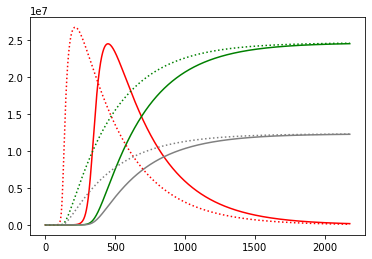

In [17]:
%%time
#Resolution using fahdFix
N=Nma
tau=0.1
fit_params=getParams(N,1,0.2,0.02,0.01,20,8)
x=np.linspace(tau,data.shape[1],int((data.shape[1])/tau))
tc=int(30/tau)#confinement
tc2=int(80/tau)#confinement
eps=10
n=x.size

x=np.linspace(tau,data.shape[1]*2,int((data.shape[1]*2)/tau))
fit_params['p'].value=1
y=fahdFix2(fit_params,x,y0)
#Plot estimated data using odint
plt.plot(y[1], label="Is",color='red')
plt.plot(y[2],label="Rs", color='green')
plt.plot(y[3],label="Ds", color='gray')

fit_params['p'].value=2
y=fahdFix2(fit_params,x,y0)
#Plot estimated data using odint
plt.plot(y[1], linestyle='dotted',label="Is",color='red')
plt.plot(y[2],linestyle='dotted',label="Rs", color='green')
plt.plot(y[3],linestyle='dotted',label="Ds", color='gray')

In [18]:
def objective(params,f,x,data,y0):
    # Initial number of infected and recovered individuals, I0 and R0.
    ndata, _ = data.shape
    resid = 0.0*data[:]
    ret=f(params,x,y0)
    
    for i in range(ndata):
        resid[i, :] =data[i, :] - ret[i,:]#/(1e-5+data[i, :])
    return resid.flatten()


# SIR Fitting

(4, 100)
[[Variables]]
    N:      3.689e+07 (fixed)
    p:      10628.4853 +/- 168.981946 (1.59%) (init = 1)
    beta:   0.23639106 +/- 0.00145242 (0.61%) (init = 0.2)
    gamma:  0.04320853 +/- 9.1794e-04 (2.12%) (init = 0.02)
    sigma:  0.00127292 +/- 4.6482e-04 (36.52%) (init = 0.01)
    tc:     20 (fixed)
    eps:    8 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(p, gamma)    = -0.605
    C(p, beta)     =  0.484
    C(p, sigma)    = -0.386
    C(beta, sigma) =  0.200


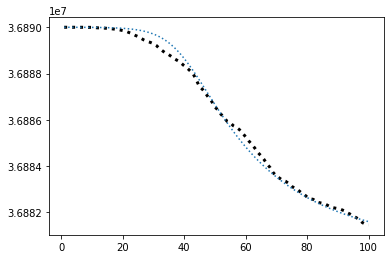

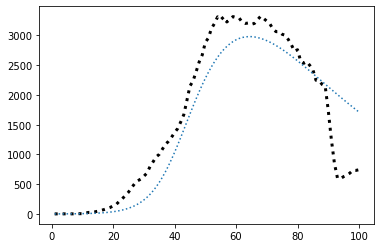

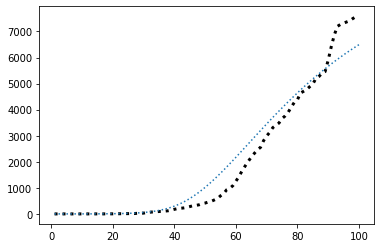

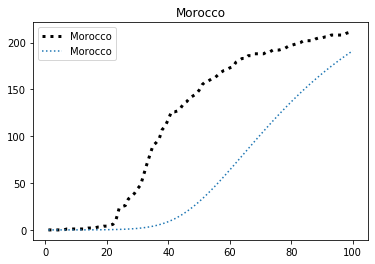

In [19]:
m=120 #last day
N=Nma
fit_params=getParams(N,1,0.2,0.02,0.01,20,8)#params: population,p,beta,gamma,sigma
y0,data,ac=getCountryData("MA",N,m)
fit_params["p"].value=1
fit_params["p"].vary=True
fit_params["N"].vary=False
fit_params["N"].value=N
n=data.shape[1]
n1=100
x=np.linspace(1,n1,n1)
d=data[:,1:n1+1]
print(d.shape)

out = minimize(objective, fit_params, nan_policy='omit', args=(f,x,d,y0))
report_fit(out.params)
x=np.linspace(1,n1,n1)
y=f(out.params,x,y0)

plt.figure()
plt.plot(x,d[0],linestyle="dotted",linewidth=3,color="black", label="Morocco")
plt.plot(x,y[0],linestyle="dotted", label="Morocco")

plt.figure()
plt.plot(x,d[1],linestyle="dotted",linewidth=3,color="black", label="Morocco")
plt.plot(x,y[1],linestyle="dotted", label="Morocco")

plt.figure()
plt.plot(x,d[2],linestyle="dotted",linewidth=3,color="black", label="Morocco")
plt.plot(x,y[2],linestyle="dotted", label="Morocco")

plt.figure()
plt.plot(x,d[3],linestyle="dotted",linewidth=3,color="black", label="Morocco")
plt.plot(x,y[3],linestyle="dotted", label="Morocco")

plt.title("Morocco")
plt.legend()
plt.savefig("maExp.png", dpi=150)

[[Variables]]
    N:      3.689e+07 (fixed)
    p:      1 (fixed)
    beta:   1.18374241 +/- 0.19970602 (16.87%) (init = 0.2)
    gamma:  0.99999823 +/- 0.16103303 (16.10%) (init = 0.02)
    sigma:  0.12252634 +/- 0.05825004 (47.54%) (init = 0.01)
    tc:     20 (fixed)
    eps:    8 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(beta, gamma)  =  0.974
    C(beta, sigma)  =  0.780
    C(gamma, sigma) =  0.617


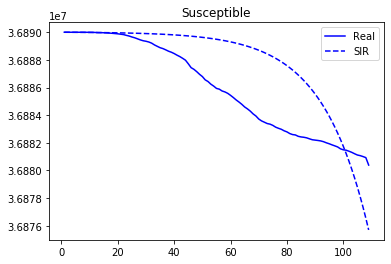

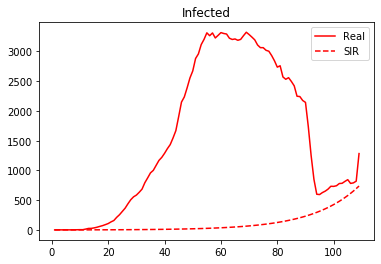

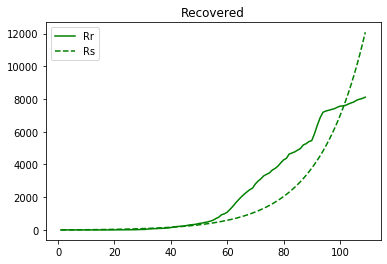

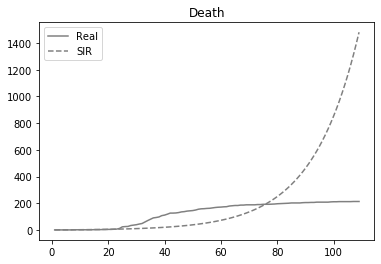

In [12]:
m=110 #last day
N=Nma
fit_params=getParams(N,1,0.2,0.02,0.01,20,8)
y0,data,ac=getCountryData("MA",N,m)
n=data.shape[1]
x=np.linspace(1,n,n)
fit_params["p"].value=1
fit_params["p"].vary=False

out = minimize(objective, fit_params, nan_policy='omit', args=(f,x,data,y0))
report_fit(out.params)
y=f(out.params,x,y0)

plt.figure()
plt.plot(x,data[0],label="Real", color='blue')
plt.plot(x,y[0], label="SIR",linestyle='dashed',color='blue')

plt.legend()
plt.title("Susceptible")
plt.savefig("Sresults.png", dpi=150)

plt.figure()
plt.plot(x,data[1],label="Real", color='red')
plt.plot(x,y[1], label="SIR",linestyle='dashed',color='red')

plt.legend()
plt.title("Infected")
plt.savefig("Iresults.png", dpi=150)

plt.figure()
plt.plot(x,data[2],label="Rr", color='green')
plt.plot(x,y[2],label="Rs",linestyle='dashed', color='green')

plt.legend()
plt.title("Recovered")
plt.savefig("Rresults.png", dpi=150)

plt.figure()
plt.plot(x,data[3],label="Real", color='gray')
plt.plot(x,y[3],label="SIR",linestyle='dashed', color='gray')

plt.legend()
plt.title("Death")
plt.savefig("Dresults.png", dpi=150)


# SIRP Fitting

[[Variables]]
    N:      3.689e+07 (fixed)
    p:      1 (fixed)
    beta:   1.18374241 +/- 0.19970602 (16.87%) (init = 0.2)
    gamma:  0.99999823 +/- 0.16103303 (16.10%) (init = 0.02)
    sigma:  0.12252634 +/- 0.05825004 (47.54%) (init = 0.01)
    tc:     20 (fixed)
    eps:    8 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(beta, gamma)  =  0.974
    C(beta, sigma)  =  0.780
    C(gamma, sigma) =  0.617
[[Variables]]
    N:      3.689e+07 (fixed)
    p:      9253.13936 +/- 148.419861 (1.60%) (init = 1)
    beta:   0.21366130 +/- 0.00120398 (0.56%) (init = 0.2)
    gamma:  0.04631931 +/- 0.00100434 (2.17%) (init = 0.02)
    sigma:  0.00109861 +/- 4.3895e-04 (39.96%) (init = 0.01)
    tc:     20 (fixed)
    eps:    8 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(p, gamma)    = -0.651
    C(p, sigma)    = -0.411
    C(p, beta)     =  0.275
    C(beta, sigma) =  0.265
    C(beta, gamma) =  0.236


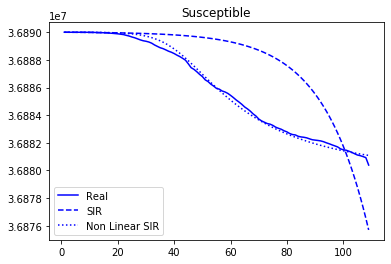

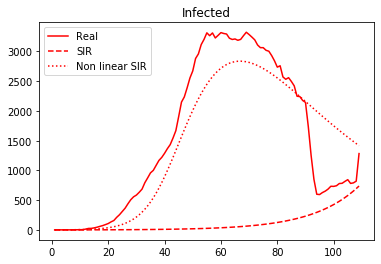

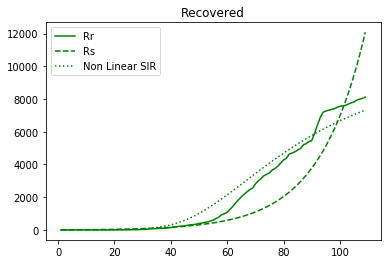

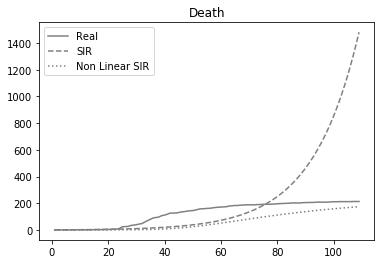

In [13]:
m=110 #last day
N=Nma
fit_params=getParams(N,1,0.2,0.02,0.01,20,8)
y0,data,ac=getCountryData("MA",N,m)

n=data.shape[1]
x=np.linspace(1,n,n)
fit_params["p"].value=1
fit_params["p"].vary=True
outf = minimize(objective, fit_params, nan_policy='omit', args=(fahdFix,x,data,y0))#method='Nelder-Mead',tol=1e-10,

fit_params["p"].value=1
fit_params["p"].vary=False
out = minimize(objective, fit_params, nan_policy='omit', args=(f,x,data,y0))

report_fit(out.params)
report_fit(outf.params)
y=f(out.params,x,y0)
yf=fahdFix(outf.params,x,y0)


plt.figure()
plt.plot(x,data[0],label="Real", color='blue')
plt.plot(x,y[0], label="SIR",linestyle='dashed',color='blue')
plt.plot(x,yf[0],label='Non Linear SIR', linestyle="dotted",color='blue')
plt.legend()
plt.title("Susceptible")
plt.savefig("Sresults.png", dpi=150)

plt.figure()
plt.plot(x,data[1],label="Real", color='red')
plt.plot(x,y[1], label="SIR",linestyle='dashed',color='red')
plt.plot(x,yf[1],linestyle='dotted', label="Non linear SIR",color='red')
plt.legend()
plt.title("Infected")
plt.savefig("Iresults.png", dpi=150)

plt.figure()
plt.plot(x,data[2],label="Rr", color='green')
plt.plot(x,y[2],label="Rs",linestyle='dashed', color='green')
plt.plot(x,yf[2],linestyle='dotted',label="Non Linear SIR", color='green')
plt.legend()
plt.title("Recovered")
plt.savefig("Rresults.png", dpi=150)

plt.figure()
plt.plot(x,data[3],label="Real", color='gray')
plt.plot(x,y[3],label="SIR",linestyle='dashed', color='gray')
plt.plot(x,yf[3],linestyle='dotted',label="Non Linear SIR", color='gray')
plt.legend()
plt.title("Death")
plt.savefig("Dresults.png", dpi=150)




109


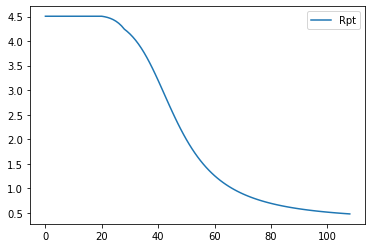

In [14]:
R0=outf.params["beta"].value/(outf.params["sigma"].value+outf.params["gamma"].value)
tc=outf.params["tc"].value
eps=outf.params["eps"].value
n=x.size
print(n)
pp=outf.params["p"].value
P=np.ones(n)
for i in range(tc,tc+eps+1):
  P[i]=1+(pp-1)*(i-tc)/eps 
for i in range(tc+eps+1,n):
  P[i]=pp 
rt=R0*(yf[0]/N)**P
plt.figure()
plt.plot(rt,label='Rpt')
plt.legend()


# Etape1:
Teste 1:  
presentation du caractère exponentielle dans les premiers 15 jours 
de l'épédimie  par paquet (Italy espagne france allemagne ) +(maroc algérie egypte afrique du sud) +(Chilie brazil mexique iran)

mettre en evidence le caractère exponenetille de l'épedemie







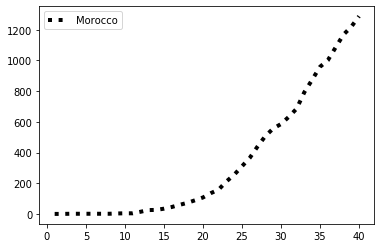

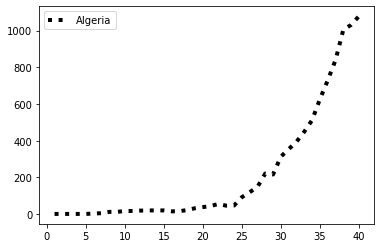

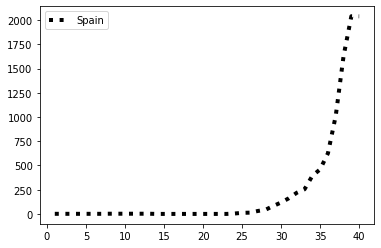

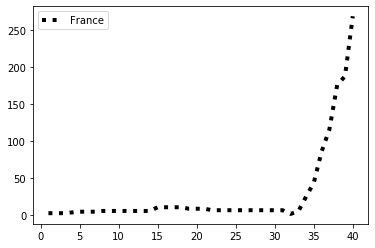

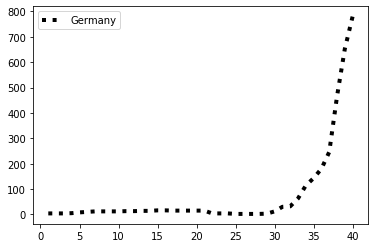

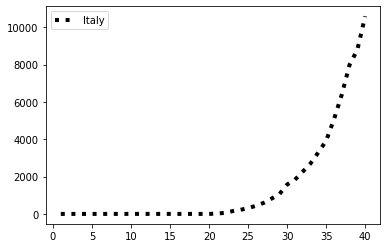

In [21]:
def expEffect(country,N,T,m,figName):
    y0,data,ac=getCountryData(country,N,m)
    n=data.shape[1]
    y0,data,ac=getCountryData(country,N,m)
    n=data.shape[1]
    x=np.linspace(1,T,T)
    plt.figure()
    plt.plot(x,data[1,0:T],linestyle="dotted",linewidth=4,color="black", label=country)
    plt.legend()
    plt.savefig(figName, dpi=150)

expEffect("Morocco",Nma,40,110,"expMA.png")
expEffect("Algeria",Nalg,40,110,"expAlg.png")
expEffect("Spain",Nalg,40,110,"expES.png")
expEffect("France",Nalg,40,110,"expFR.png")
expEffect("Germany",Nalg,40,110,"expDE.png")
expEffect("Italy",Nalg,40,110,"expIT.png")

(4, 119)


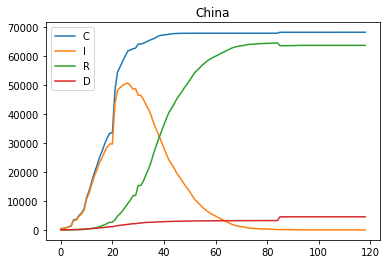

In [22]:
y0CH,dataCH,acCH=getCountryData("china",Nch,m)
n=dataCH.shape[1]
print(dataCH.shape)
x=np.linspace(1,n,n)
#plt.subplot(3, 3, 6)
plt.figure()
plt.plot(acCH,label="C")
plt.plot(dataCH[1], label="I")
plt.plot(dataCH[2], label="R")
plt.plot(dataCH[3], label="D")
plt.title("China")
plt.legend()
plt.savefig("wuhan.png", dpi=150)


#Etape 2:
Test2: lancer SIR classique sur les premiers 15 jours, fitter sur les données, recuperer $ \alpha, \beta, et \gamma $ en suite tracer les courbes SIR et les SIRP en variant les p $p=10 , 100, 50000$
L'impact de $p$ est du confinement  et l et voir  l impact de la puissance 





In [242]:
def pEffect(country,figName,P,N,T,tmax,limits,zoom):  
    print("=================",country,"===================")
    y0,data,ac=getCountryData(country,N,tmax)
    print("y0: ",y0)
    print("tc:",T)
    print("P: ",P)
    fit_params=getParams(N,1,0.2,0.02,0.01,T,8)    
    fit_params["p"].vary=False
    x=np.linspace(1,T,T)
    d=np.array([data[0,0:T],data[1,0:T],data[2,0:T],data[3,0:T]])
    out = minimize(objective, fit_params,  args=(f,x,d,y0))
    report_fit(out.params)
    x=np.linspace(1,tmax,tmax)
    out.params["p"].value=P[0]
    y=f(out.params,x,[N-1,1,0,0])
    out.params["p"].value=P[1]
    yf1=f(out.params,x,[N-1,1,0,0])
    out.params["p"].value=P[2]
    yf2=f(out.params,x,[N-1,1,0,0])
    out.params["p"].value=P[3]
    yf3=f(out.params,x,[N-1,1,0,0])
    
    from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
    
    fig, ax = plt.subplots(1, 2,sharex=True,figsize=[12, 4.8])
    axins= zoomed_inset_axes(ax[0],zoom, loc=2)
    ax[0].plot(y[1],label="$p^{*}="+str(P[0])+"$")
    ax[0].plot(yf1[1],color="black",label="$p^{*}="+str(P[1])+"$")
    ax[0].plot(yf2[1],color="green",label="$p^{*}="+str(P[2])+"$")
    ax[0].plot(yf3[1],color="red",label="$p^{*}="+str(P[3])+"$")
    #ax.plot(N-yf3[0],label="p=1.6")
    
    
    axins.plot(y[1])
    axins.plot(yf1[1],color="black")
    axins.plot(yf2[1],color="green")
    axins.plot(yf3[1],color="red")
    
    x1, x2, y1, y2=limits
    axins.set_xlim(x1, x2) # apply the x-limits
    axins.set_ylim(y1, y2) # apply the y-limits[0,0][0,0]
    
    plt.yticks(visible=False)
    plt.xticks(visible=False)
    
    from mpl_toolkits.axes_grid1.inset_locator import mark_inset
    mark_inset(ax[0], axins, loc1=3, loc2=4, fc="none", ec="0.5")

    ax[0].legend()
    #ax.set_title("Italy")

    #plt.figure()
    ax[1].plot(N-y[0],label="$p^{*}="+str(P[0])+"$")
    ax[1].plot(N-yf1[0],color="black",label="$p^{*}="+str(P[1])+"$")
    ax[1].plot(N-yf2[0],color="green",label="$p^{*}="+str(P[2])+"$")
    ax[1].plot(N-yf3[0],color="red",label="$p^{*}="+str(P[3])+"$")
    
    ax[1].legend()
    fig.suptitle(country)
    fig.savefig(figName, dpi=150)
    print("================Day 100=================")
    print("With LockDown:",ac[100],"Case")
    print("Without LockDown:",np.sum(y[1:,100]))
   

================= Morocco ===================
y0:  [36889998.0, 1, 0, 0]
tc: 45
P:  [1, 1.2, 1.4, 1.6]
[[Variables]]
    N:      3.689e+07 (fixed)
    p:      1 (fixed)
    beta:   0.21989543 +/- 0.00895783 (4.07%) (init = 0.2)
    gamma:  0.02575269 +/- 0.00783389 (30.42%) (init = 0.02)
    sigma:  0.01763839 +/- 0.00770817 (43.70%) (init = 0.01)
    tc:     45 (fixed)
    eps:    8 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(beta, gamma)  =  0.624
    C(beta, sigma)  =  0.609
    C(gamma, sigma) = -0.235
================Day 100=================
With LockDown: 8537 Case
Without LockDown: 21174822.430691026


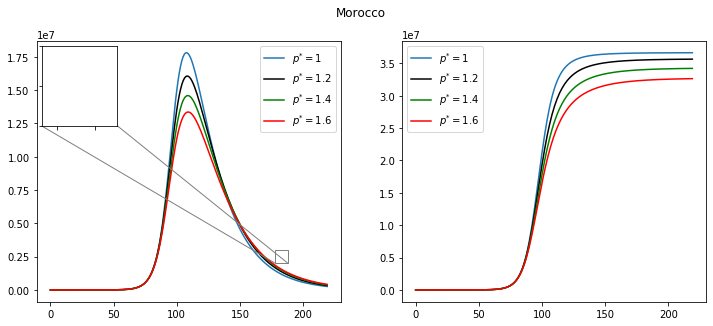

In [249]:
#Morocco
P=[1,1.2,1.4,1.6]
limits=178, 188, 0.2e7, 0.3e7
zoom=6
pEffect("Morocco","pEffectMA_zoom.png",P,Nma,45,220,limits,zoom) 

================= Algeria ===================
y0:  [43799998.0, 1, 0, 0]
tc: 40
P:  [1, 1.2, 1.4, 1.6]
[[Variables]]
    N:      4.38e+07 (fixed)
    p:      1 (fixed)
    beta:   0.22217021 +/- 0.00369398 (1.66%) (init = 0.2)
    gamma:  0.01662588 +/- 0.00324028 (19.49%) (init = 0.02)
    sigma:  0.02167542 +/- 0.00327009 (15.09%) (init = 0.01)
    tc:     40 (fixed)
    eps:    8 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(beta, sigma)  =  0.613
    C(beta, gamma)  =  0.606
    C(gamma, sigma) = -0.250
================Day 100=================
With LockDown: 9935 Case
Without LockDown: 30110665.09269192


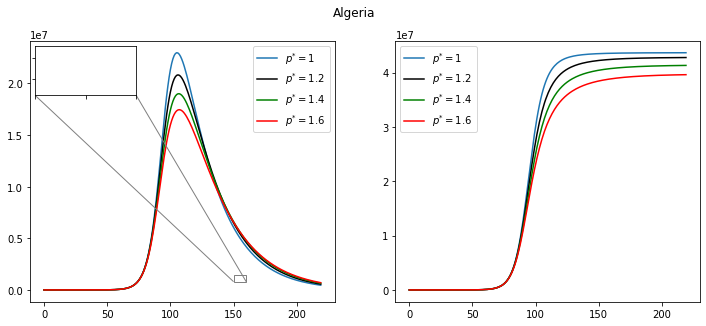

In [250]:
#Algeria
P=[1,1.2,1.4,1.6]
limits=150, 160, 0.08e7, 0.14e7
zoom=8
pEffect("Algeria","pEffectAlg_zoom.png",P,Nalg,40,220,limits,zoom) 


================= Germany ===================
y0:  [83699998.0, 1, 0, 0]
tc: 60
P:  [1, 1.2, 1.4, 1.6]
[[Variables]]
    N:      8.37e+07 (fixed)
    p:      1 (fixed)
    beta:   0.20343954 +/- 0.00228179 (1.12%) (init = 0.2)
    gamma:  0.01874942 +/- 0.00204140 (10.89%) (init = 0.02)
    sigma:  0.00148311 +/- 0.00197800 (133.37%) (init = 0.01)
    tc:     60 (fixed)
    eps:    8 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(beta, gamma)  =  0.610
    C(beta, sigma)  =  0.580
    C(gamma, sigma) = -0.289
================Day 100=================
With LockDown: 169430 Case
Without LockDown: 44513250.744006544


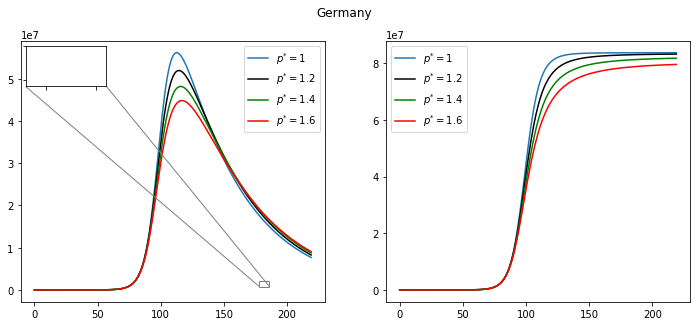

In [251]:
#Germany
P=[1,1.2,1.4,1.6]
limits=178, 186, 0.08e7, 0.2e7
zoom=8
pEffect("Germany","pEffectAlg_zoom.png",P,Nde,60,220,limits,zoom) 


================= France ===================
y0:  [65259996.0, 2, 0, 0]
tc: 60
P:  [1, 1.2, 1.4, 1.6]
[[Variables]]
    N:      6.526e+07 (fixed)
    p:      1 (fixed)
    beta:   0.17696179 +/- 0.00162902 (0.92%) (init = 0.2)
    gamma:  0.01425655 +/- 0.00144932 (10.17%) (init = 0.02)
    sigma:  0.00680420 +/- 0.00142642 (20.96%) (init = 0.01)
    tc:     60 (fixed)
    eps:    8 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(beta, gamma)  =  0.606
    C(beta, sigma)  =  0.591
    C(gamma, sigma) = -0.279
================Day 100=================
With LockDown: 167886 Case
Without LockDown: 6034466.092263142


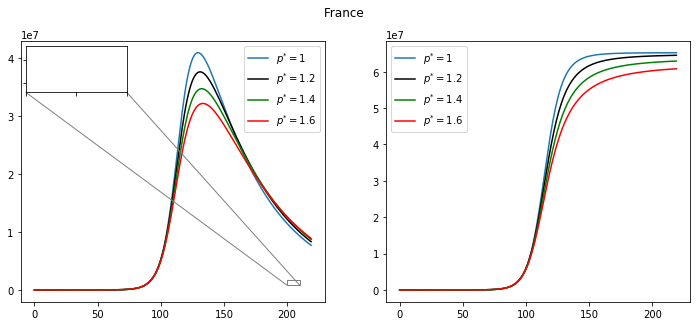

In [252]:
#France
P=[1,1.2,1.4,1.6]
limits=200, 210, 0.08e7, 0.18e7
zoom=8
pEffect("France","pEffectFR_zoom.png",P,Nfr,60,220,limits,zoom) 

================= Spain ===================
y0:  [46699998.0, 1, 0, 0]
tc: 50
P:  [1, 1.2, 1.4, 1.6]
[[Variables]]
    N:      4.67e+07 (fixed)
    p:      1 (fixed)
    beta:   0.23996337 +/- 0.00199676 (0.83%) (init = 0.2)
    gamma:  0.01935118 +/- 0.00175125 (9.05%) (init = 0.02)
    sigma:  0.01268951 +/- 0.00173203 (13.65%) (init = 0.01)
    tc:     50 (fixed)
    eps:    8 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(beta, gamma)  =  0.608
    C(beta, sigma)  =  0.598
    C(gamma, sigma) = -0.270
================Day 100=================
With LockDown: 228030 Case
Without LockDown: 43684084.97720983


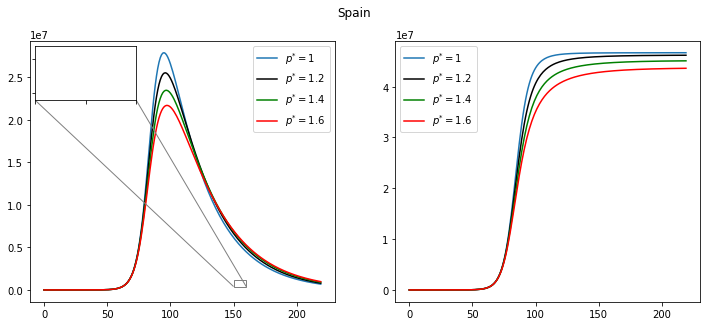

In [255]:
#Spain
P=[1,1.2,1.4,1.6]
limits=150, 160, 0.04e7, 0.12e7 
zoom=8
pEffect("Spain","pEffectES_zoom.png",P,Nsp,50,220,limits,zoom) 



================= Italy ===================
y0:  [60463996.0, 2, 0, 0]
tc: 50
P:  [1, 1.2, 1.4, 1.6]
[[Variables]]
    N:      6.0464e+07 (fixed)
    p:      1 (fixed)
    beta:   0.25724026 +/- 0.00459813 (1.79%) (init = 0.2)
    gamma:  0.02790464 +/- 0.00392788 (14.08%) (init = 0.02)
    sigma:  0.02270995 +/- 0.00389209 (17.14%) (init = 0.01)
    tc:     50 (fixed)
    eps:    8 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(beta, gamma)  =  0.623
    C(beta, sigma)  =  0.615
    C(gamma, sigma) = -0.230
================Day 100=================
With LockDown: 219814 Case
Without LockDown: 54443593.67394322


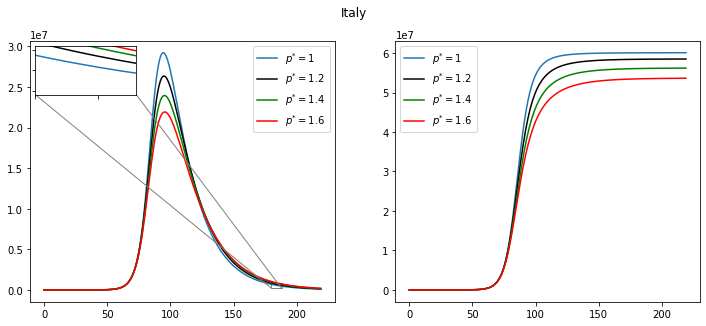

In [256]:
#Italy
P=[1,1.2,1.4,1.6]
limits=180, 188, 0.02e7, 0.08e7
zoom=10
pEffect("Italy","pEffectIT_zoom.png",P,Nit,50,220,limits,zoom) 

# Etape3
Dans le test 3 on fit notre modèle et nous recuperons les nouveaux parametre $\alpha, \beta, \gamma et p $.
Nous fittons egalement SIR.

Comparer d'abord fitting de notre modele et du modèle SIR.
mettre en evidence que le fitting avec notre modèle donne meilleure resultasts vu qu il prend en considération la distanciation social( indicateur de fitting).
(Donner plus d'importance et donnée recente)


Tracer le $R_p(t)$ pour chaque pays 
Mesuré l'impact du confinement en comparant notre modèle  avec (SIR avec les parametres $(\alpha, \beta, \gamma)$ de l'etape 2)
-

In [223]:
def result(country,figName,N,tmax,tc,eps):
  print("=================",country,"=======================")
  print("tc:",tc,"eps:",eps)
  y0,data,ac=getCountryData(country,N,tmax)
  fit_params=getParams(N,1,0.2,0.02,0.01,tc,eps)  
  n=data.shape[1]
  x=np.linspace(1,n,n)
  eps=fit_params["eps"].value
  fit_params["p"].value=1
  fit_params["p"].vary=False
  out = minimize(objective, fit_params, nan_policy='omit', args=(f,x,data,y0))

  fit_params["p"].value=1
  fit_params["p"].vary=True
  outf = minimize(objective, fit_params, nan_policy='omit', args=(fahdFix,x,data,y0))

  print("===============SIR==================")
  print(report_fit(out.params))
  print("===============SIRP==================")
  print(report_fit(outf.params))
  print("====================================")
  out.params["p"].value=1
  x=np.linspace(1,n+10,n+10)
  y=f(out.params,x,[N-1,1,0,0])
  yf=fahdFix(outf.params,x,[N-1,1,0,0])

  #plt.figure(country)

  fig, axs= plt.subplots(2, 2,sharex=True,figsize=[14, 6])
  fig.suptitle(country)
  
  axs[0, 0].set_title('Susceptible')
  axs[0, 0].plot(data[0],linestyle="dotted",linewidth=4,color="black", label="Data")
  #axs[0, 0].scatter(x,d[0],linestyle="dotted",color="black", label="Real")
  axs[0, 0].plot(y[0],color="C10",label="SIR")
  axs[0, 0].plot(yf[0],color="red",label="Our Model")
  axs[0, 0].legend()
  
  axs[0, 1].set_title('Active')
  axs[0, 1].plot(data[1],linestyle="dotted",linewidth=4,color="black", label="Data")
  axs[0, 1].plot(y[1],color="C10",label="SIR")
  axs[0, 1].plot(yf[1],color="red",label="Our Model")  
  axs[0, 1].legend()

  axs[1, 0].set_title('Recovered')
  axs[1, 0].plot(data[2],linestyle="dotted",linewidth=4,color="black", label="Data")
  axs[1, 0].plot(y[2],color="C10",label="SIR")
  axs[1, 0].plot(yf[2],color="red",label="Our Model")
  axs[1, 0].legend()
    
  axs[1, 1].set_title('Death')
  axs[1, 1].plot(data[3],linestyle="dotted",linewidth=4,color="black", label="Data")
  axs[1, 1].plot(y[3],color="C10",label="SIR")
  axs[1, 1].plot(yf[3],color="red",label="Our Model")
  axs[1, 1].legend()
  
    
  R0=outf.params["beta"].value/(outf.params["sigma"].value+outf.params["gamma"].value)

  n=x.size
  pp=outf.params["p"].value
  P=np.ones(n)
  for i in range(tc,tc+eps+1):
    P[i]=1+(pp-1)*(i-tc)/eps 
  for i in range(tc+eps+1,n):
    P[i]=pp 
  rt=R0*(yf[0]/N)**P
  fig.savefig(figName, dpi=150)
  return rt

================= Morocco =======================
tc: 26 eps: 8
===============SIR==================
[[Variables]]
    N:      3.689e+07 (fixed)
    p:      1 (fixed)
    beta:   1.22126511 +/- 0.18884527 (15.46%) (init = 0.2)
    gamma:  0.99999967 +/- 0.15482430 (15.48%) (init = 0.02)
    sigma:  0.15437778 +/- 0.05850797 (37.90%) (init = 0.01)
    tc:     26 (fixed)
    eps:    8 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(beta, gamma)  =  0.965
    C(beta, sigma)  =  0.727
    C(gamma, sigma) =  0.521
None
===============SIRP==================
[[Variables]]
    N:      3.689e+07 (fixed)
    p:      9821.74773 +/- 166.469922 (1.69%) (init = 1)
    beta:   0.21154361 +/- 0.00110790 (0.52%) (init = 0.2)
    gamma:  0.04175114 +/- 9.1111e-04 (2.18%) (init = 0.02)
    sigma:  0.00137191 +/- 4.7384e-04 (34.54%) (init = 0.01)
    tc:     26 (fixed)
    eps:    8 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(p, gamma)    = -0.614
    C(p, sig

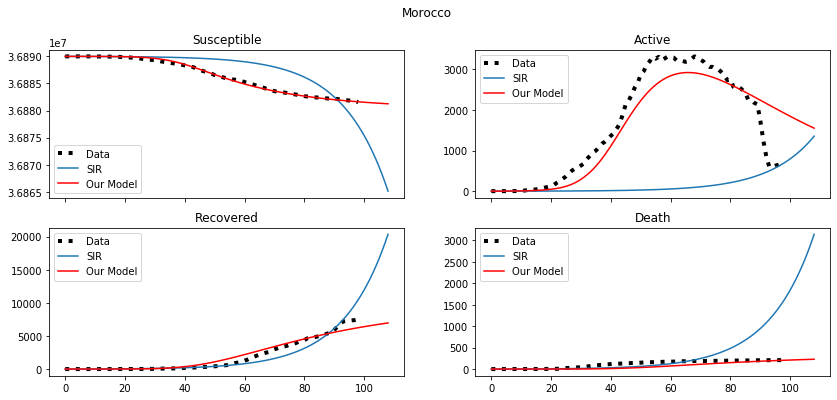

In [258]:
rtMA=result("Morocco","resultMA.png",Nma,100,26,8)

================= Algeria =======================
tc: 26 eps: 8
===============SIR==================
[[Variables]]
    N:      4.38e+07 (fixed)
    p:      1 (fixed)
    beta:   1.36749934 +/- 0.04706138 (3.44%) (init = 0.2)
    gamma:  0.99999999 +/- 0.01555674 (1.56%) (init = 0.02)
    sigma:  0.30198777 +/- 0.04682392 (15.51%) (init = 0.01)
    tc:     26 (fixed)
    eps:    8 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(beta, sigma)  =  0.943
    C(beta, gamma)  =  0.204
    C(gamma, sigma) = -0.134
None
===============SIRP==================
[[Variables]]
    N:      4.38e+07 (fixed)
    p:      8086.18695 +/- 150.803072 (1.86%) (init = 1)
    beta:   0.18720912 +/- 9.2491e-04 (0.49%) (init = 0.2)
    gamma:  0.04548430 +/- 9.7250e-04 (2.14%) (init = 0.02)
    sigma:  0.00643650 +/- 5.5945e-04 (8.69%) (init = 0.01)
    tc:     26 (fixed)
    eps:    8 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(p, gamma)     = -0.636
    C(beta, gamm

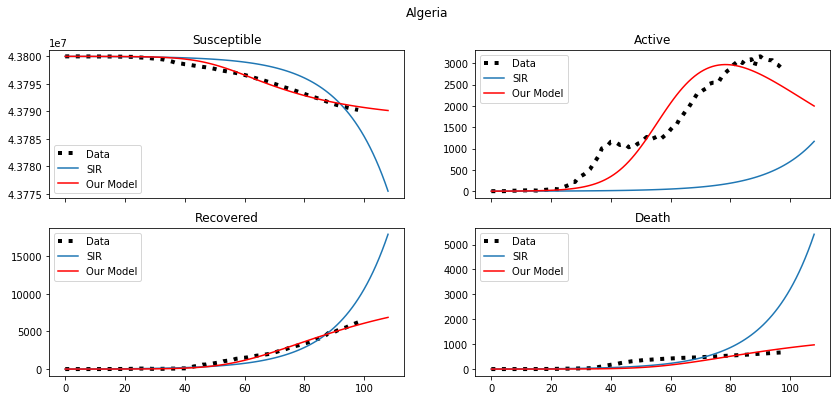

In [231]:
rtAlg=result("Algeria","resultAlg.png",Nalg,100,26,8)

================= Spain =======================
tc: 30 eps: 8
===============SIR==================
[[Variables]]
    N:      4.67e+07 (fixed)
    p:      1 (fixed)
    beta:   1.49543506 +/- 0.45403002 (30.36%) (init = 0.2)
    gamma:  0.99999990 +/- 0.32543581 (32.54%) (init = 0.02)
    sigma:  0.39163616 +/- 0.15428697 (39.40%) (init = 0.01)
    tc:     30 (fixed)
    eps:    8 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(beta, gamma)  =  0.980
    C(beta, sigma)  =  0.908
    C(gamma, sigma) =  0.805
None
===============SIRP==================
[[Variables]]
    N:      4.67e+07 (fixed)
    p:      452.286058 +/- 2.78021718 (0.61%) (init = 1)
    beta:   0.23973950 +/- 4.3641e-04 (0.18%) (init = 0.2)
    gamma:  0.03478090 +/- 3.2464e-04 (0.93%) (init = 0.02)
    sigma:  0.00818803 +/- 2.2208e-04 (2.71%) (init = 0.01)
    tc:     30 (fixed)
    eps:    8 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(p, gamma)     = -0.563
    C(p, sigma) 

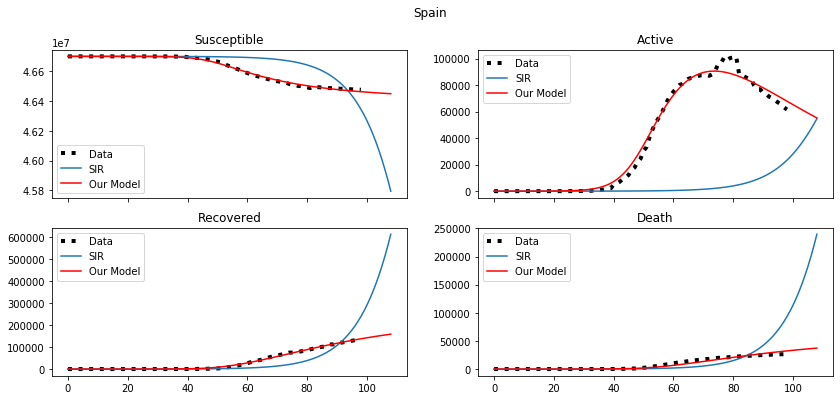

In [229]:
rtES=result("Spain","resultES.png",Nsp,100,30,8)

================= Germany =======================
tc: 30 eps: 8
===============SIR==================
[[Variables]]
    N:      8.37e+07 (fixed)
    p:      1 (fixed)
    beta:   1.25477482 +/- 0.41321242 (32.93%) (init = 0.2)
    gamma:  0.99999988 +/- 0.35867368 (35.87%) (init = 0.02)
    sigma:  0.15257834 +/- 0.07770839 (50.93%) (init = 0.01)
    tc:     30 (fixed)
    eps:    8 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(beta, gamma)  =  0.991
    C(beta, sigma)  =  0.775
    C(gamma, sigma) =  0.681
None
===============SIRP==================
[[Variables]]
    N:      8.37e+07 (fixed)
    p:      887.661008 +/- 11.7336907 (1.32%) (init = 1)
    beta:   0.23731968 +/- 8.4136e-04 (0.35%) (init = 0.2)
    gamma:  0.05906339 +/- 9.8996e-04 (1.68%) (init = 0.02)
    sigma:  0.00295122 +/- 4.8673e-04 (16.49%) (init = 0.01)
    tc:     30 (fixed)
    eps:    8 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(beta, gamma)  =  0.666
    C(p, gamm

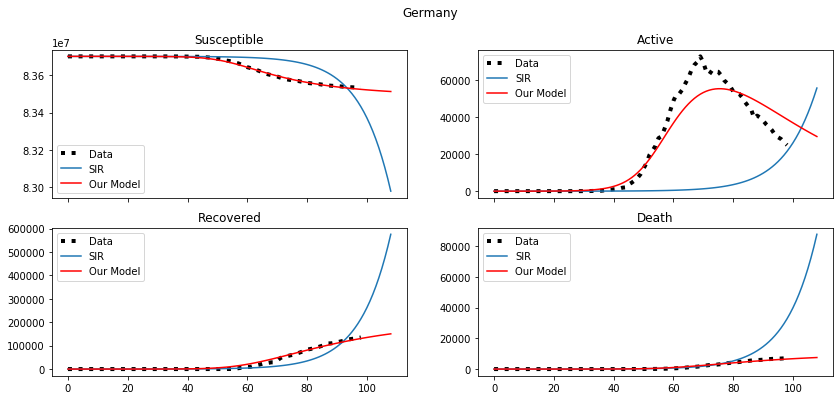

In [233]:
rtDE=result("Germany","resultDE.png",Nde,100,30,8)

================= France =======================
tc: 30 eps: 8
===============SIR==================
[[Variables]]
    N:      4.67e+07 (fixed)
    p:      1 (fixed)
    beta:   0.21260365 +/- 0.01231206 (5.79%) (init = 0.2)
    gamma:  0.06320080 +/- 0.00942448 (14.91%) (init = 0.02)
    sigma:  0.03468535 +/- 0.00840603 (24.24%) (init = 0.01)
    tc:     30 (fixed)
    eps:    8 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(beta, gamma) =  0.756
    C(beta, sigma) =  0.684
None
===============SIRP==================
[[Variables]]
    N:      4.67e+07 (fixed)
    p:      441.898402 +/- 5.47698964 (1.24%) (init = 1)
    beta:   0.17784301 +/- 5.2226e-04 (0.29%) (init = 0.2)
    gamma:  0.02036041 +/- 4.2617e-04 (2.09%) (init = 0.02)
    sigma:  0.01066173 +/- 3.8469e-04 (3.61%) (init = 0.01)
    tc:     30 (fixed)
    eps:    8 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(beta, sigma) =  0.512
    C(p, gamma)    = -0.497
    C(beta, gamma) =

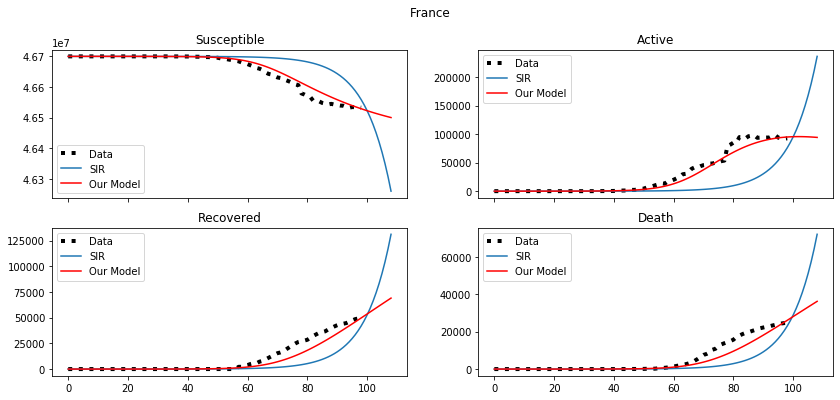

In [235]:
rtFR=result("France","resultFR.png",Nsp,100,30,8)

================= Italy =======================
tc: 30 eps: 8
===============SIR==================
[[Variables]]
    N:      4.67e+07 (fixed)
    p:      1 (fixed)
    beta:   0.29117736 +/- 0.03201074 (10.99%) (init = 0.2)
    gamma:  0.12582976 +/- 0.02388628 (18.98%) (init = 0.02)
    sigma:  0.05091827 +/- 0.01755660 (34.48%) (init = 0.01)
    tc:     30 (fixed)
    eps:    8 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(beta, gamma)  =  0.859
    C(beta, sigma)  =  0.723
    C(gamma, sigma) =  0.269
None
===============SIRP==================
[[Variables]]
    N:      4.67e+07 (fixed)
    p:      548.242311 +/- 2.09270414 (0.38%) (init = 1)
    beta:   0.22181738 +/- 2.8407e-04 (0.13%) (init = 0.2)
    gamma:  0.01856919 +/- 1.3280e-04 (0.72%) (init = 0.02)
    sigma:  0.00755063 +/- 1.1366e-04 (1.51%) (init = 0.01)
    tc:     30 (fixed)
    eps:    8 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(p, gamma)    = -0.487
    C(p, beta)   

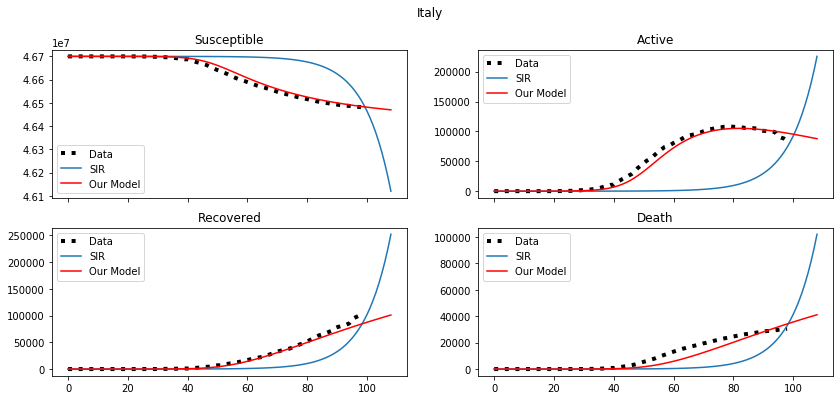

In [234]:
rtIT=result("Italy","resultIT.png",Nsp,100,30,8)

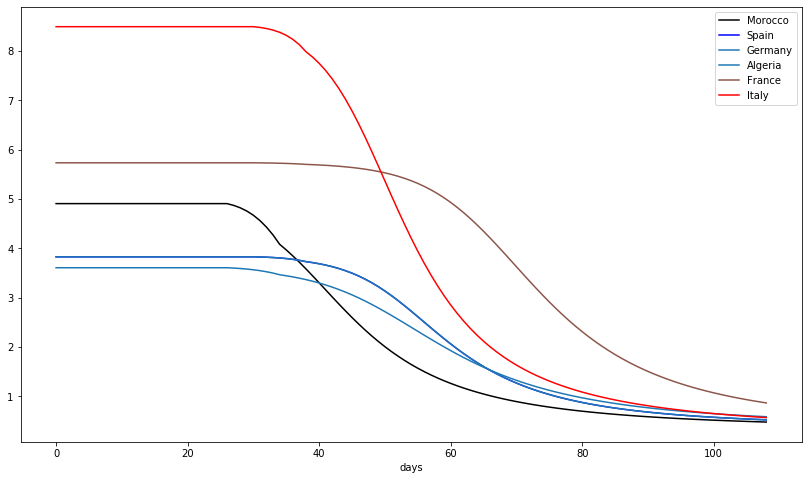

In [237]:
plt.figure(figsize=[14, 8])
plt.plot(rtMA, color="black",label='Morocco')
plt.plot(rtES, color="blue",label='Spain')
plt.plot(rtDE, color="C10", label='Germany')
#plt.plot(rtMX,label='Mexico')
plt.plot(rtAlg,label='Algeria')
plt.plot(rtFR, color="C5", label='France')
plt.plot(rtIT, color="red",label='Italy')
plt.legend()
#ax2.set_xlabel
plt.xlabel("days")
plt.savefig("rpt.png", dpi=150)